## Gathering Data

In [1862]:
import tweepy
import requests
import pandas as pd
import json
import time
import math
import re

In [1863]:
# Import the Twitter archive CSV file into a DataFrame
arc_df = pd.read_csv('twitter_archive_enhanced.csv')

In [1864]:
# Download tweet image predictions TSV using the Requests library and write it to image_predictions.tsv
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
with open('image_predictions.tsv', mode='wb') as file:
    file.write(response.content)
    
# Import the tweet image predictions TSV file into a DataFrame
img_df = pd.read_csv('image_predictions.tsv', sep='\t')

In [1865]:
# Declare Twitter API keys and access tokens
consumer_key = 'YOUR CONSUMER KEY'
consumer_secret = 'YOUR CONSUMER SECRET'
access_token = 'YOUR ACCESS TOKEN'
access_secret = 'YOUR ACCESS SECRET'

In [1866]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

In [1867]:
api = tweepy.API(auth_handler=auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [275]:
# Using the tweet IDs in the Twitter archive, query the Twitter API for each tweet's JSON

start = time.time() # start timer

with open('getstatus_error.txt', 'w') as errfile: 
    valid_ids = 0
    err_ids = 0
    tweet_ids = arc_df.tweet_id
    with open('tweet_json.txt', 'w', encoding='utf-8') as outfile:
        for i, tweet_id in tweet_ids.iteritems():
            try:
                print("%s# %s" % (str(i+1), tweet_id))
                # Get tweet data using Twitter API
                tweet = api.get_status(tweet_id, tweet_mode='extended')
                json_content = tweet._json
                
                # Write each tweet's JSON data to its own line in a file
                json.dump(json_content, outfile)
                outfile.write('\n')
                valid_ids += 1
            except tweepy.TweepError as e:
                err_ids += 1
                err_str = []
                err_str.append(str(tweet_id))
                err_str.append(': ')
                err_str.append(e.response.json()['errors'][0]['message'])
                err_str.append('\n')
                errfile.write(''.join(err_str))
                print(''.join(err_str))
                continue
        print("%s %s" % ('Valid tweets:', valid_ids))
        print("%s %s" % ('Error tweets:', err_ids))
        
end = time.time() # end timer
print((end - start)/(1000*60))

In [1868]:
# List of dictionaries to read tweet's JSON data line by line and later convert to a DataFrame
df_list = []
with open('tweet_json.txt', 'r') as json_file:
    for line in json_file:
        status = json.loads(line)
        
        # Append to list of dictionaries
        df_list.append({'tweet_id': status['id'],
                        'retweet_count': status['retweet_count'],
                        'favorite_count': status['favorite_count'],
                        'display_text_range': status['display_text_range']
                       })

# Create a DataFrame with tweet ID, retweet count, favorite count and display_text_range
status_df = pd.DataFrame(df_list, columns = ['tweet_id', 'retweet_count', 'favorite_count', 'display_text_range'])

---

## Assessing Data

In [1869]:
arc_df.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
312,835264098648616962,NaN,NaN,2017-02-24 23:04:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Lola. Her hobbies include being precious ...,NaN,NaN,NaN,https://www.gofundme.com/lolas-life-saving-sur...,12,10,Lola,None,None,None,None
2076,670838202509447168,NaN,NaN,2015-11-29 05:34:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Pink dogs here. Unreasonably long necks. Left ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670838202...,4,10,None,None,None,None,None
2093,670780561024270336,NaN,NaN,2015-11-29 01:45:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Traviss. He has no ears. Two rare dogs...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670780561...,7,10,Traviss,None,None,None,None
752,778990705243029504,NaN,NaN,2016-09-22 16:13:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Jay. He's really h*ckin happy about th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778990705...,11,10,Jay,None,None,None,None
1471,693993230313091072,NaN,NaN,2016-02-01 03:04:14 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",These lil fellas are the best of friends. 12/1...,NaN,NaN,NaN,https://vine.co/v/i5ETazP5hrm,12,10,None,None,None,None,None


`arc_df` (Twitter archive) columns:
- **tweet_id**: the unique identifier for each tweet
- **in_reply_to_status_id**: if the represented Tweet is a reply, this field will contain the integer representation of the original Tweet’s ID
- **in_reply_to_user_id**: if the represented Tweet is a reply, this field will contain the integer representation of the original Tweet’s author ID
- **timestamp**: time when this Tweet was created
- **source**: utility used to post the Tweet, as an HTML-formatted string. e.g. Twitter for Android, Twitter for iPhone, Twitter Web Client
- **text**: actual UTF-8 text of the status update
- **retweeted_status_id**: if the represented Tweet is a retweet, this field will contain the integer representation of the original Tweet’s ID
- **retweeted_status_user_id**: if the represented Tweet is a retweet, this field will contain the integer representation of the original Tweet’s author ID
- **retweeted_status_timestamp**: time of retweet
- **expanded_urls**: tweet URL
- **rating_numerator**: numerator of the rating of a dog. Note: ratings almost always greater than 10
- **rating_denominator**: denominator of the rating of a dog. Note: ratings almost always have a denominator of 10
- **name**: name of the dog
- **doggo**: one of the 4 dog "stage"
- **floofer**: one of the 4 dog "stage"
- **pupper**: one of the 4 dog "stage"
- **puppo**: one of the 4 dog "stage"

In [1870]:
arc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [1889]:
# Check if there are any records in arc_df which are retweets
len(arc_df[arc_df.retweeted_status_id.isnull() == False])

181

In [1894]:
# Check if there are any records in arc_df whose corresponding record with same tweet_id is missing in img_df table
len(arc_df[~arc_df.tweet_id.isin(img_df.tweet_id)])

281

In [1871]:
# Sort by rating_denominator values
arc_df.rating_denominator.value_counts().sort_index()

0         1
2         1
7         1
10     2333
11        3
15        1
16        1
20        2
40        1
50        3
70        1
80        2
90        1
110       1
120       1
130       1
150       1
170       1
Name: rating_denominator, dtype: int64

In [1872]:
# Sort by rating_numerator values
arc_df.rating_numerator.value_counts().sort_index()

0         2
1         9
2         9
3        19
4        17
5        37
6        32
7        55
8       102
9       158
10      461
11      464
12      558
13      351
14       54
15        2
17        1
20        1
24        1
26        1
27        1
44        1
45        1
50        1
60        1
75        2
80        1
84        1
88        1
99        1
121       1
143       1
144       1
165       1
182       1
204       1
420       2
666       1
960       1
1776      1
Name: rating_numerator, dtype: int64

In [993]:
arc_df.name.value_counts().sort_index(ascending=False)

very             5
unacceptable     1
this             1
the              8
such             1
space            1
quite            4
one              4
old              1
officially       1
not              2
my               1
mad              2
light            1
life             1
just             4
infuriating      1
incredibly       1
his              1
getting          2
by               1
an               7
all              1
actually         2
a               55
Zuzu             1
Zooey            1
Zoey             3
Zoe              1
Ziva             1
                ..
Apollo           1
Antony           1
Anthony          1
Anna             1
Angel            1
Andy             1
Andru            1
Anakin           2
Amélie           1
Amy              1
Ambrose          1
Amber            1
Alice            2
Alfy             1
Alfie            5
Alf              1
Alexanderson     1
Alexander        1
Alejandro        1
Aldrick          1
Albus            2
Albert      

In [1873]:
# Number of records whose both doggo and floofer columns are not None
len(arc_df[(arc_df.doggo != 'None') & (arc_df.floofer != 'None')])

1

In [1874]:
# Number of records whose both doggo and pupper columns are not None
len(arc_df[(arc_df.doggo != 'None') & (arc_df.pupper != 'None')])

12

In [1875]:
# Number of records whose both doggo and pupper columns are not None
len(arc_df[(arc_df.doggo != 'None') & (arc_df.puppo != 'None')])

1

In [1876]:
# Number of records whose both floofer and pupper columns are not None
len(arc_df[(arc_df.floofer != 'None') & (arc_df.pupper != 'None')])

0

In [1878]:
# Number of records whose both floofer and puppo columns are not None
len(arc_df[(arc_df.floofer != 'None') & (arc_df.puppo != 'None')])

0

In [1879]:
# Number of records whose both pupper and puppo columns are not None
len(arc_df[(arc_df.pupper != 'None') & (arc_df.puppo != 'None')])

0

In [1880]:
img_df.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1950,863079547188785154,https://pbs.twimg.com/media/C_pGRInUwAAmTY_.jpg,1,Lakeland_terrier,0.275242,True,Airedale,0.190569,True,teddy,0.102595,False
527,676617503762681856,https://pbs.twimg.com/media/CWPUB9TWwAALPPx.jpg,1,Chihuahua,0.841084,True,Pomeranian,0.120530,True,Pekinese,0.006600,True
1409,770414278348247044,https://pbs.twimg.com/media/CrEPsfWXEAAKvem.jpg,1,maillot,0.580528,False,maillot,0.081449,False,golden_retriever,0.053570,True
854,696488710901260288,https://pbs.twimg.com/media/CapsyfkWcAQ41uC.jpg,1,briard,0.369063,True,Scotch_terrier,0.168204,True,giant_schnauzer,0.120553,True
899,699788877217865730,https://pbs.twimg.com/media/CbYmRHyWEAASNzm.jpg,1,Border_terrier,0.355060,True,toy_poodle,0.169736,True,Norwegian_elkhound,0.099884,True


`img_df` (tweet image predictions) columns:
- **tweet_id**: the unique identifier for each tweet
- **jpg_url**: dog's image URL
- **img_num**: the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images)
- **p1**: algorithm's #1 prediction for the image in the tweet
- **p1_conf**: how confident the algorithm is in its #1 prediction
- **p1_dog**: whether or not the #1 prediction is a breed of dog
- **p2**: algorithm's #2 prediction for the image in the tweet
- **p2_conf**: how confident the algorithm is in its #2 prediction
- **p2_dog**: whether or not the #2 prediction is a breed of dog
- **p3**: algorithm's #3 prediction for the image in the tweet
- **p3_conf**: how confident the algorithm is in its #3 prediction
- **p3_dog**: whether or not the #3 prediction is a breed of dog

In [1881]:
img_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [1882]:
status_df.sample(5)

,tweet_id,retweet_count,favorite_count,display_text_range
531,807106840509214720,56299,106551,"[0, 61]"
1508,691096613310316544,1016,3242,"[0, 140]"
888,759446261539934208,555,1841,"[0, 140]"
1083,737826014890496000,2000,5727,"[0, 114]"
930,753398408988139520,2171,6361,"[0, 55]"


`status_df` (tweet status) columns:
- **id**: the unique identifier for each tweet
- **retweet_count**: number of times this Tweet has been retweeted
- **favorite_count**: indicates approximately how many times this Tweet has been liked by Twitter users
- **display_text_range**: an array of two unicode code point indices, identifying the inclusive start and exclusive end of the displayable content of the Tweet

In [1883]:
status_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2351 entries, 0 to 2350
Data columns (total 4 columns):
tweet_id              2351 non-null int64
retweet_count         2351 non-null int64
favorite_count        2351 non-null int64
display_text_range    2351 non-null object
dtypes: int64(3), object(1)
memory usage: 73.5+ KB


### Quality
##### `arc_df` (Twitter archive) table
- contains retweets and therefore, duplicates
- many *tweet_id*(s) of `arc_df` table are missing in `img_df` (image predictions) table
- erroneous datatypes (*in_reply_to_status_id, in_reply_to_user_id and timestamp* columns)
- unnecessary html tags in *source* column in place of utility name e.g. `<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>`
- *text* column contains untruncated text instead of displayable text
- *rating_numerator* column has values less than 10 as well as some very large numbers (e.g. 1176)
- *rating_denominator* column has values other than 10
- erroneous dog names starting with lowercase characters (e.g. a, an, actually, by)
- some records have more than one dog stage

### Tidiness
- `arc_df` without any duplicates (i.e. retweets) will have empty *retweeted_status_id, retweeted_status_user_id* and *retweeted_status_timestamp* columns, which can be dropped
- *doggo, floofer, pupper* and *puppo* columns in `arc_df` table should be merged into one column named *"stage"*
- *"breed"* column should be added in `arc_df` table; its values based on *p1_conf* and *p1_dog* columns of `img_df` (image predictions) table
- *retweet_count* and *favorite_count* columns from `status_df` (tweet status) table should be joined with `arc_df` table

---

## Cleaning Data

In [1921]:
# Take a copy of arc_df on which the cleaning tasks will be performed
archive_clean = arc_df.copy()

### Quality

#### `arc_df`: contains retweets and therefore, duplicates

##### Define
Keep only those rows in `arc_df` table that are original tweets and NOT retweets (i.e. *retweeted_status_id* column is null). Delete the rest.

##### Code

In [1922]:
archive_clean = archive_clean[archive_clean.retweeted_status_id.isnull()]

##### Test

In [1887]:
len(archive_clean[archive_clean.retweeted_status_id.isnull() == False])

0

#### `arc_df`: many *tweet_id*(s) of `arc_df` table are missing in `img_df` (image predictions) table

##### Define
Keep only those records in `arc_df` table whose *tweet_id* exists in `img_df` table

##### Code

In [1923]:
archive_clean = archive_clean[archive_clean.tweet_id.isin(img_df.tweet_id)]

##### Test

In [1924]:
len(archive_clean[~archive_clean.tweet_id.isin(img_df.tweet_id)])

0

### Tidiness

#### `arc_df` table without any duplicates (i.e. retweets) have empty *retweeted_status_id, retweeted_status_user_id* and *retweeted_status_timestamp* columns, which can be dropped

In [1925]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      1994 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     1994 non-null object
source                        1994 non-null object
text                          1994 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1994 non-null object
rating_numerator              1994 non-null int64
rating_denominator            1994 non-null int64
name                          1994 non-null object
doggo                         1994 non-null object
floofer                       1994 non-null object
pupper                        1994 non-null object
puppo                         1994 non-null object
dtypes: float64(4), int64(3), object(1

##### Define
Drop *retweeted_status_id, retweeted_status_user_id* and *retweeted_status_timestamp* columns from `arc_df` table

#### Code

In [1926]:
archive_clean.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1, inplace=True)

#### Test

In [1927]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                 1994 non-null int64
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
timestamp                1994 non-null object
source                   1994 non-null object
text                     1994 non-null object
expanded_urls            1994 non-null object
rating_numerator         1994 non-null int64
rating_denominator       1994 non-null int64
name                     1994 non-null object
doggo                    1994 non-null object
floofer                  1994 non-null object
pupper                   1994 non-null object
puppo                    1994 non-null object
dtypes: float64(2), int64(3), object(9)
memory usage: 233.7+ KB


### Quality

#### `arc_df`: erroneous datatypes (*in_reply_to_status_id, in_reply_to_user_id* and *timestamp* columns)

##### Define
Convert *in_reply_to_status_id* and *in_reply_to_user_id* to data type integer. Convert *timestamp* to datetime data type

##### Code

In [1928]:
archive_clean.in_reply_to_status_id = archive_clean.in_reply_to_status_id.fillna(0)
archive_clean.in_reply_to_user_id = archive_clean.in_reply_to_user_id.fillna(0)

archive_clean.in_reply_to_status_id = archive_clean.in_reply_to_status_id.astype(np.int64)
archive_clean.in_reply_to_user_id = archive_clean.in_reply_to_user_id.astype(np.int64)

archive_clean.timestamp = pd.to_datetime(archive_clean.timestamp)

##### Test

In [1929]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                 1994 non-null int64
in_reply_to_status_id    1994 non-null int64
in_reply_to_user_id      1994 non-null int64
timestamp                1994 non-null datetime64[ns]
source                   1994 non-null object
text                     1994 non-null object
expanded_urls            1994 non-null object
rating_numerator         1994 non-null int64
rating_denominator       1994 non-null int64
name                     1994 non-null object
doggo                    1994 non-null object
floofer                  1994 non-null object
pupper                   1994 non-null object
puppo                    1994 non-null object
dtypes: datetime64[ns](1), int64(5), object(8)
memory usage: 233.7+ KB


#### `arc_df`: unnecessary html tags in *source* column in place of utility name e.g. `<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>`

##### Define
Strip all html anchor tags (i.e. `<a..></a>`) in *source* column and retain just the text in between the tags. Convert the datatype from string to categorical.

#### Code

In [1930]:
archive_clean.source = archive_clean.source.str.replace(r'<(?:a\b[^>]*>|/a>)', '')

In [1931]:
archive_clean.source = archive_clean.source.astype('category')

#### Test

In [1932]:
archive_clean.source.value_counts()

Twitter for iPhone    1955
Twitter Web Client      28
TweetDeck               11
Name: source, dtype: int64

#### `arc_df`: *text* column contains untruncated text instead of displayable text

##### Define
Using the *display_text_range* of `status_df` table, extract displayable text from text column

##### Code

In [1933]:
# Before extraction: untruncated text of first 3 records
print(archive_clean.iloc[0].text)
print(archive_clean.iloc[1].text)
print(archive_clean.iloc[2].text)

This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU
This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV
This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB


In [1934]:
# merge status_df's display_text_range column to archive_clean to extract text using range values
archive_clean = pd.merge(archive_clean, status_df[['tweet_id', 'display_text_range']], on='tweet_id')

In [1935]:
# using display_text_range of archive_clean, extract displayable text
for i, row in archive_clean.iterrows():
    text_range = row.display_text_range
    display_text = row.text[text_range[0]:text_range[1]]
    archive_clean.set_value(i, 'text', display_text)

In [1936]:
# drop display_text_range column
archive_clean.drop('display_text_range', axis=1, inplace=True)

##### Test

In [1937]:
# After extraction: first 3 records now show displayable text
print(archive_clean.iloc[0].text)
print(archive_clean.iloc[1].text)
print(archive_clean.iloc[2].text)  

This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10
This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10
This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10


#### `arc_df`: *rating_denominator* column has values other than 10

##### Define
For records whose *rating_denominator* is greater than 10 and divisible by 10, use the quotient as the divisor to divide the *rating_numerator*. If the numerator turns out to be divisible (i.e. remainder=0), assign this quotient as the *rating_numerator*.

For the remaining records, check if the *text* column contains any fraction whose denominator is 10. If it does, update the *rating_denominator* to 10. Additionally, update the *rating_numerator* with the numerator value of this fraction.

##### Code

In [1939]:
# regex to match fractions
pattern = "\s*(\d+([.]\d+)?([/]\d+))"

# function which will match the above pattern and return an array of fractions, if any
def tokens(x):
  return [m.group(1) for m in re.finditer(pattern, x)]

In [1943]:
# iterate through all those records whose rating_denominator is not 10
for i, row in archive_clean[archive_clean.rating_denominator != 10].iterrows():
    d = row.rating_denominator
    
    # if rating_denominator is greater than 10 and divisible by 10
    if d > 10 and d%10 == 0:
        # assign divisor as the quotient
        divisor = d/10
        n = row.rating_numerator
        
        # if rating_numerator is greater than 10 and divisible by the divisor
        if n%divisor == 0:
            # reassign rating_denominator as 10
            archive_clean.set_value(i, 'rating_denominator', 10)
            # reassign rating_numerator as the quotient of rating_numerator by divisor
            archive_clean.set_value(i, 'rating_numerator', int(n/divisor))
    
    # for all those records whose rating_denominator is either less than 10 or not divisible by 10
    else:
        # extract all fractions(ratings) from text using tokens function
        ratings = tokens(row.text)
        # iterate through all the fractions
        for rating in ratings:
            # if denominator of any such fraction is equal to 10
            if rating.split('/')[1] == '10':
                # reassign rating_denominator as 10
                archive_clean.set_value(i, 'rating_denominator', 10)
                # reassign rating_numerator as the numerator value of this fraction
                archive_clean.set_value(i, 'rating_numerator', int(round(float(rating.split('/')[0]))))
                break

##### Test

In [1944]:
archive_clean.rating_denominator.value_counts()

10    1993
7        1
Name: rating_denominator, dtype: int64

#### `arc_df`: *rating_numerator* column has values less than or equal to 10 as well as some very large numbers (e.g. 1176)

##### Define
For all those records whose *rating numerator* is either less than or equal to 10 or greater than 10 but has a very high value, check if the text contains any fraction whose denominator is 10. If it does, update the *rating_numerator* with the numerator value of this fraction.

In [1949]:
archive_clean[(archive_clean.rating_numerator <= 10) | (archive_clean.rating_numerator > 14)].rating_numerator.value_counts().sort_index()

0         2
1         4
2        10
3        19
4        15
5        33
6        32
7        51
8        95
9       152
10      422
24        1
26        1
27        1
75        1
420       1
1776      1
Name: rating_numerator, dtype: int64

##### Code

In [1961]:
# for rows whose rating numerator is either less than or equal to 10 OR
# greater than 10 but has a very high value (consider greater than 14)
for i, row in archive_clean[(archive_clean.rating_numerator <= 10) | (archive_clean.rating_numerator > 14)].iterrows():
    ratings = tokens(row.text)
    for rating in ratings:        
        if rating.split('/')[1] == '10':
            n = int(round(float(rating.split('/')[0])))
            if (row.rating_numerator == 10 and n > 10) or (row.rating_numerator != 10 and n >= 10):
                archive_clean.set_value(i, 'rating_numerator', n)
                break

##### Test

In [1962]:
archive_clean[(archive_clean.rating_numerator <= 10) | (archive_clean.rating_numerator > 14)].rating_numerator.value_counts().sort_index()

0         2
1         4
2         9
3        19
4        14
5        31
6        32
7        51
8        94
9       152
10      421
24        1
420       1
1776      1
Name: rating_numerator, dtype: int64

#### `arc_df`: erroneous dog names starting with lowercase characters (e.g. a, an, actually, by)

##### Define
Replace all lowercase values of *name* column with None

##### Code

In [1963]:
archive_clean['name'][archive_clean['name'].str.match('[a-z]+')] = 'None'

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


##### Test

In [1964]:
archive_clean.name[archive_clean.name == 'None'].value_counts()

None    644
Name: name, dtype: int64

In [1966]:
# Sort ascending by name to check if there are more names starting with a lowercase alphabet
archive_clean.name.value_counts().sort_index(ascending=False)

Zuzu            1
Zooey           1
Zoey            3
Zoe             1
Ziva            1
Zeus            1
Zeke            3
Zeek            1
Zara            1
Yogi            2
Yoda            1
Wyatt           3
Wishes          1
Winston         8
Winnie          4
Winifred        1
Wilson          3
Willy           1
Willow          1
Willie          1
William         1
Willem          1
Wiggles         1
Wesley          1
Watson          2
Walter          3
Wally           2
Wallace         3
Walker          1
Waffles         3
               ..
Apollo          1
Antony          1
Anthony         1
Anna            1
Angel           1
Andy            1
Andru           1
Anakin          1
Amélie          1
Amy             1
Ambrose         1
Amber           1
Alice           2
Alfy            1
Alfie           4
Alf             1
Alexanderson    1
Alexander       1
Alejandro       1
Aldrick         1
Albus           2
Albert          2
Al              1
Akumi           1
Aja       

#### `arc_df`: some records have more than one dog stage

In [1956]:
print(len(archive_clean[(archive_clean.doggo != 'None') & (archive_clean.floofer != 'None')]))
print(len(archive_clean[(archive_clean.doggo != 'None') & (archive_clean.puppo != 'None')]))
print(len(archive_clean[(archive_clean.doggo != 'None') & (archive_clean.pupper != 'None')]))

1
1
9


##### Define
There is one record that has both *doggo* and *floofer* and another record that has both *doggo* and *puppo*. For these 2 records, take a look at the text manually to decide one dog stage for each of them. For ambiguous texts, set both the column values as None.

There are 9 records which have both *doggo* and *pupper*. As per the dogtionary, *doggo* and *pupper* are sometimes used interchangeably. Therefore, set *pupper* column as None for these 9 records.

##### Code

In [1958]:
for i, row in archive_clean[((archive_clean.doggo != 'None') & (archive_clean.floofer != 'None'))
                   | ((archive_clean.doggo != 'None') & (archive_clean.puppo != 'None'))].iterrows():
    print('%s %s\n'%(row.tweet_id, row.text))

855851453814013952 Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for

854010172552949760 At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs



In [1959]:
# based on the above texts, doggo should be set as None for both the records
archive_clean['doggo'][archive_clean.tweet_id.isin([855851453814013952, 854010172552949760])] = 'None'

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [1957]:
# set pupper column as None for records which have both doggo and pupper
archive_clean['pupper'][(archive_clean.doggo != 'None') & (archive_clean.pupper != 'None')] = 'None'

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


##### Test

In [1967]:
len(archive_clean[((archive_clean.doggo != 'None') & (archive_clean.pupper != 'None'))
                  | ((archive_clean.doggo != 'None') & (archive_clean.floofer != 'None')) 
                  | ((archive_clean.doggo != 'None') & (archive_clean.puppo != 'None'))])

0

### Tidiness

#### doggo, floofer, pupper and puppo columns in `arc_df` table should be merged into one column named "stage"

In [1969]:
archive_clean.doggo.value_counts()

None     1922
doggo      72
Name: doggo, dtype: int64

In [1970]:
archive_clean.floofer.value_counts()

None       1986
floofer       8
Name: floofer, dtype: int64

In [1971]:
archive_clean.pupper.value_counts()

None      1791
pupper     203
Name: pupper, dtype: int64

In [1972]:
archive_clean.puppo.value_counts()

None     1971
puppo      23
Name: puppo, dtype: int64

##### Define
Merge the *doggo*, *floofer*, *pupper* and *puppo* columns to a *stage* column. Convert the datatype from string to categorical as it helps with analysis and visualization and saves memory on disk.

Drop the *doggo*, *floofer*, *pupper* and *puppo* columns.

##### Code

In [1974]:
# merge the doggo, floofer, pupper and puppo columns to a stage column
archive_clean['stage'] = archive_clean[['doggo', 'floofer', 'pupper', 'puppo']].max(axis=1)

In [1975]:
# convert the datatype from string to categorical
archive_clean.stage = archive_clean.stage.astype('category')

In [1976]:
# drop the doggo, floofer, pupper and puppo columns
archive_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

##### Test

In [1977]:
archive_clean.stage.value_counts()

None       1688
pupper      203
doggo        72
puppo        23
floofer       8
Name: stage, dtype: int64

In [1978]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 1993
Data columns (total 11 columns):
tweet_id                 1994 non-null int64
in_reply_to_status_id    1994 non-null int64
in_reply_to_user_id      1994 non-null int64
timestamp                1994 non-null datetime64[ns]
source                   1994 non-null category
text                     1994 non-null object
expanded_urls            1994 non-null object
rating_numerator         1994 non-null int64
rating_denominator       1994 non-null int64
name                     1994 non-null object
stage                    1994 non-null category
dtypes: category(2), datetime64[ns](1), int64(5), object(3)
memory usage: 240.0+ KB


##### The following 2 tidiness issues will be cleaned together in a single iteration
- #### *"breed"* column should be added in `arc_df` table, its values based on *p1_conf* and *p1_dog* columns of `img_df` table
- #### *retweet_count* and *favorite_count* columns from `status_df` table should be joined with `arc_df` table

##### Define
Create *breed*, *retweet_count* and *favorite_count* columns in `arc_df` table. For each tweet_id, use the `img_df` table to check if *p1_conf* is greater than 0.95 (*i.e. 95% confidence interval*) and *p1_dog* is True. If it is, set the value of *p1* column in *breed* column. 

Also, fetch the *retweet_count* and *favorite_count* columns of `status_df` table and assign those values to `arc_df` table

##### Code

In [1979]:
# create breed, retweet_count and favorite_count columns
archive_clean['breed'] = 'None'
archive_clean['retweet_count'] = 0
archive_clean['favorite_count'] = 0

In [1980]:
# iterate through all the rows of archive_clean
for i, row in archive_clean.iterrows():
    # fetch the retweet_count and favorite_count columns of status_df table and assign those values
    archive_clean.set_value(i, 'retweet_count', status_df[status_df.tweet_id == row.tweet_id].retweet_count.iloc[0])
    archive_clean.set_value(i, 'favorite_count', status_df[status_df.tweet_id == row.tweet_id].favorite_count.iloc[0])    
    
    img_prediction = img_df[img_df.tweet_id == row.tweet_id]
    p1_conf = img_prediction.p1_conf.iloc[0]
    p1_dog = img_prediction.p1_dog.iloc[0]
    #  check if p1_conf is greater than 0.95 (i.e. 95% confidence interval) and p1_dog is True
    if p1_conf >= 0.95 and p1_dog:
        archive_clean.set_value(i, 'breed', img_prediction.p1.iloc[0])

##### Test

In [1981]:
archive_clean.breed.value_counts()

None                           1808
pug                              20
Pembroke                         19
Samoyed                          19
golden_retriever                 16
Pomeranian                       13
Labrador_retriever                9
Chihuahua                         9
French_bulldog                    8
chow                              7
Bernese_mountain_dog              4
Shetland_sheepdog                 4
German_shepherd                   4
Old_English_sheepdog              3
Blenheim_spaniel                  3
beagle                            3
Pekinese                          3
malamute                          2
komondor                          2
bull_mastiff                      2
basset                            2
dalmatian                         2
Shih-Tzu                          2
vizsla                            2
English_springer                  2
Rottweiler                        2
keeshond                          2
cocker_spaniel              

In [1982]:
archive_clean[['tweet_id', 'retweet_count', 'favorite_count']].sample(5)

,tweet_id,retweet_count,favorite_count
303,824297048279236611,4435,16549
1944,666835007768551424,83,221
1493,675870721063669760,628,1771
353,815966073409433600,9835,24950
1572,674053186244734976,1430,3551


---

## Storing Data

In [1983]:
archive_clean.to_csv('twitter_archive_master.csv', encoding='utf-8', index=False)

## Analyzing Data

In [1495]:
# For analysis, create a copy of the cleaned twitter archive data
df = archive_clean.copy()

In [1984]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 1993
Data columns (total 14 columns):
tweet_id                 1994 non-null int64
in_reply_to_status_id    1994 non-null int64
in_reply_to_user_id      1994 non-null int64
timestamp                1994 non-null datetime64[ns]
source                   1994 non-null category
text                     1994 non-null object
expanded_urls            1994 non-null object
rating_numerator         1994 non-null int64
rating_denominator       1994 non-null int64
name                     1994 non-null object
stage                    1994 non-null category
breed                    1994 non-null object
retweet_count            1994 non-null int64
favorite_count           1994 non-null int64
dtypes: category(2), datetime64[ns](1), int64(7), object(4)
memory usage: 286.7+ KB


#### Analyzing number of tweets posted by WeRateDogs' over time

In [1580]:
df['timestamp'].apply(lambda x: x.strftime('%Y-%m')).value_counts().sort_index()

2015-11    296
2015-12    367
2016-01    169
2016-02    111
2016-03    120
2016-04     54
2016-05     57
2016-06     81
2016-07     88
2016-08     59
2016-09     63
2016-10     65
2016-11     53
2016-12     54
2017-01     66
2017-02     64
2017-03     48
2017-04     41
2017-05     43
2017-06     44
2017-07     49
2017-08      2
Name: timestamp, dtype: int64

#### Most used Twitter source

In [1600]:
df['source'].value_counts()

Twitter for iPhone    1955
Twitter Web Client      28
TweetDeck               11
Name: source, dtype: int64

<font color=blue>WeRateDogs has posted 98% of the tweets from iPhone.</font>

#### Analysis of rating of dogs

In [1985]:
df['rating_numerator'].value_counts().sort_index()

0         3
1         4
2         9
3        19
4        14
5        31
6        32
7        51
8        94
9       152
10      421
11      407
12      455
13      263
14       37
420       1
1776      1
Name: rating_numerator, dtype: int64

In [1986]:
df['rating_numerator'][df['rating_numerator'] > 10].value_counts().sum()

1164

<font color=blue>Out of a total of 1994 dogs rated by WeRateDogs, a total of 1164 dogs were rated above 10, which is almost 60%. However, only 2% (i.e. 37) were rated the highest (excluding the ratings of 420 and 1776 which are outliers).</font>

#### Analysis of dog breed (*as identified by image prediction*)

In [1987]:
df['breed'][df['breed'] == 'None'].value_counts()

None    1808
Name: breed, dtype: int64

<font color=blue>The breed of 1808 dogs out of 1994 (i.e. 90%) couldn't be predicted. So, at 95% confidence interval, the image prediction algorithm was able to predict the breed for 10% of the dog population of this data set.</font>

#### Analysis of retweet and favorite counts

In [1988]:
print('%s\t%s' % ('Mean Retweet Count', round(df.retweet_count.mean())))
print('%s\t%s' % ('Mean Favorite Count', round(df.favorite_count.mean())))

Mean Retweet Count	2767
Mean Favorite Count	8919


##### <font color=blue>When the dog is rated greater than 10</font>

In [1989]:
print('%s\t%s' % ('Mean Retweet Count', 
                  round(df.retweet_count[df.rating_numerator > 10].mean())))
print('%s\t%s' % ('Mean Favorite Count', 
                  round(df.favorite_count[df.rating_numerator > 10].mean())))

Mean Retweet Count	3845
Mean Favorite Count	12825


##### <font color=blue>When the dog has a name</font>

In [1990]:
print('%s\t%s' % ('Mean Retweet Count', 
                  round(df.retweet_count[df.name != 'None'].mean())))
print('%s\t%s' % ('Mean Favorite Count', 
                  round(df.favorite_count[df.name != 'None'].mean())))

Mean Retweet Count	2741
Mean Favorite Count	9397


##### <font color=blue>Categorized on dog-stage</font>

In [1991]:
print('Doggo')
print('%s\t%s' % ('Mean Retweet Count', 
                  round(df.retweet_count[df.stage == 'doggo'].mean())))
print('%s\t%s' % ('Mean Favorite Count', 
                  round(df.favorite_count[df.stage == 'doggo'].mean())))

print('Floofer')
print('%s\t%s' % ('Mean Retweet Count', 
                  round(df.retweet_count[df.stage == 'floofer'].mean())))
print('%s\t%s' % ('Mean Favorite Count', 
                  round(df.favorite_count[df.stage == 'floofer'].mean())))

print('Pupper')
print('%s\t%s' % ('Mean Retweet Count', 
                  round(df.retweet_count[df.stage == 'pupper'].mean())))
print('%s\t%s' % ('Mean Favorite Count', 
                  round(df.favorite_count[df.stage == 'pupper'].mean())))

print('Puppo')
print('%s\t%s' % ('Mean Retweet Count', 
                  round(df.retweet_count[df.stage == 'puppo'].mean())))
print('%s\t%s' % ('Mean Favorite Count', 
                  round(df.favorite_count[df.stage == 'puppo'].mean())))

Doggo
Mean Retweet Count	6701
Mean Favorite Count	18418
Floofer
Mean Retweet Count	4739
Mean Favorite Count	13639
Pupper
Mean Retweet Count	2349
Mean Favorite Count	7170
Puppo
Mean Retweet Count	6976
Mean Favorite Count	22623


In [1861]:
df.name.value_counts()

None        644
Charlie      11
Lucy         10
Cooper       10
Oliver       10
Penny         9
Tucker        9
Sadie         8
Winston       8
Daisy         7
Toby          7
Lola          7
Stanley       6
Jax           6
Bo            6
Bella         6
Koda          6
Milo          5
Louis         5
Leo           5
Rusty         5
Chester       5
Dave          5
Oscar         5
Scout         5
Buddy         5
Bailey        5
Clark         4
Winnie        4
Clarence      4
           ... 
Kirk          1
Grizzie       1
Iggy          1
Wishes        1
Fido          1
Bronte        1
Kayla         1
Dante         1
Mairi         1
Sweet         1
Jerome        1
Tupawc        1
Chef          1
Livvie        1
Rorie         1
Nugget        1
Lambeau       1
Shikha        1
Glenn         1
Richie        1
Napolean      1
Blue          1
Hanz          1
Boston        1
Dunkin        1
Edd           1
Kyro          1
Kial          1
Gerbald       1
Ashleigh      1
Name: name, Length: 914,

----

## Visualizing Data

In [1992]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [12, 9]

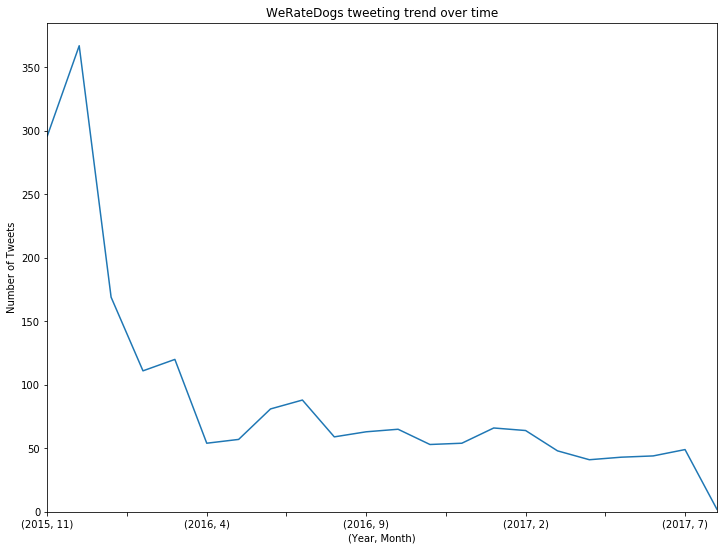

In [1993]:
data = df.tweet_id.groupby([df["timestamp"].dt.year, df["timestamp"].dt.month]).count()
ax = data.plot('line', title='WeRateDogs tweeting trend over time')
ax.set_xlabel("(Year, Month)")
ax.set_ylabel("Number of Tweets")
ax.set_ylim(0, )
plt.savefig('tweet_trend')

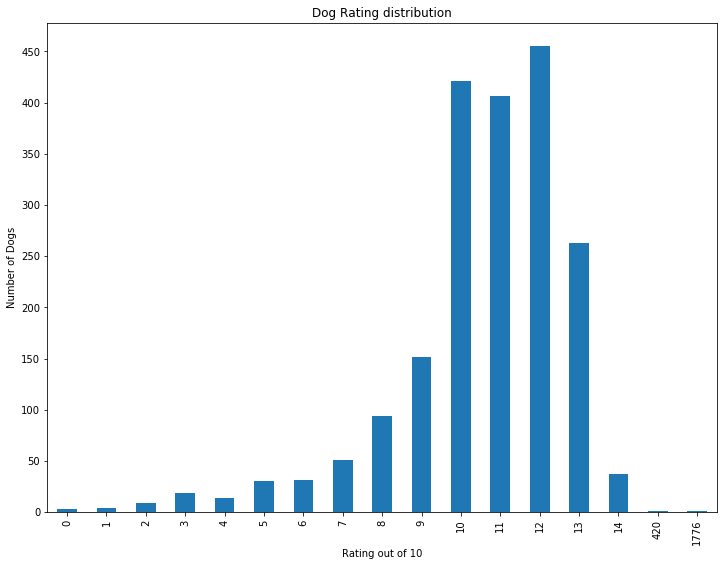

In [1994]:
ax = df.rating_numerator.value_counts().sort_index().plot('bar', title = 'Dog Rating distribution')
ax.set_xlabel("Rating out of 10")
ax.set_ylabel("Number of Dogs")
ax.set_yticks([0, 50, 100, 150, 200, 250, 300, 350, 400, 450])
plt.savefig('rating_dist')

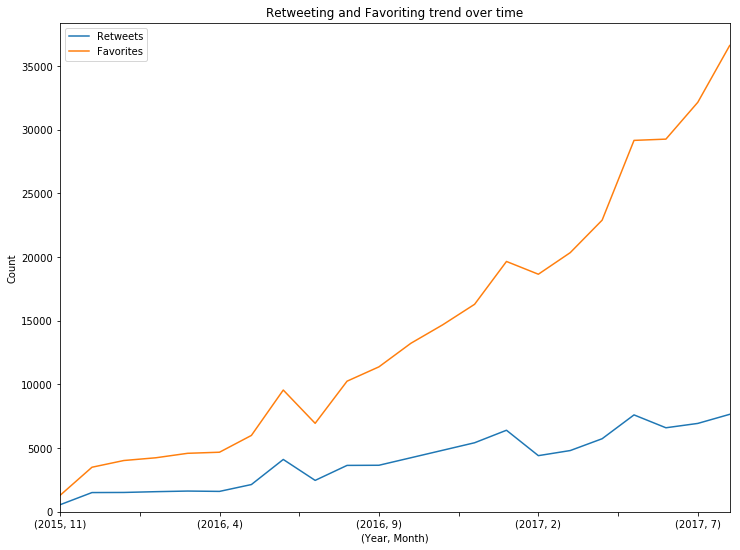

In [1996]:
plt.subplots(1, sharex=True)
df.retweet_count.groupby([df["timestamp"].dt.year, df["timestamp"].dt.month]).mean().plot('line')
df.favorite_count.groupby([df["timestamp"].dt.year, df["timestamp"].dt.month]).mean().plot('line').set_ylim(0, )
plt.title('Retweeting and Favoriting trend over time')
plt.ylabel('Count')
plt.xlabel('(Year, Month)')
plt.legend(('Retweets', 'Favorites'))
plt.savefig('ret_fav')

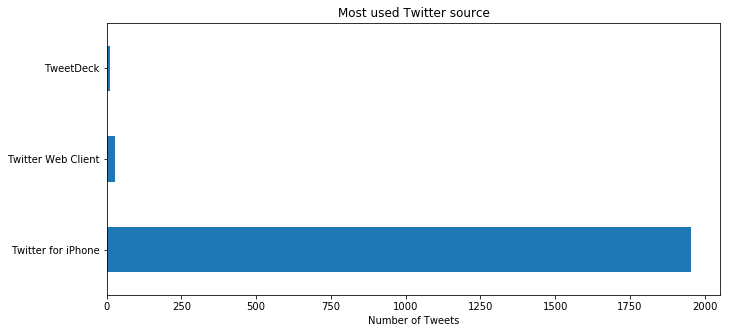

In [1997]:
df['source'].value_counts().plot('barh', figsize=(11,5), title='Most used Twitter source').set_xlabel("Number of Tweets")
plt.savefig('twitter_source')

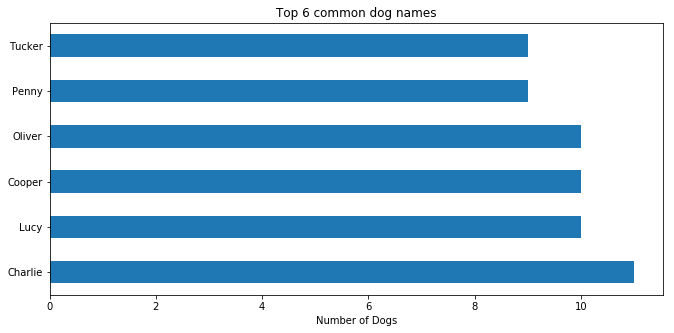

In [1998]:
df.name.value_counts()[1:7].plot('barh', figsize=(11,5), title='Top 6 common dog names').set_xlabel("Number of Dogs")
plt.savefig('dog_names')